In [24]:
# source source.me before launching jupyter
# export DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c

In [25]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4
Thu May 30 10:34:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:1A:00.0 Off |                  N/A |
| 31%   32C    P8               3W / 250W |   5375MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----

In [26]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [27]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [28]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

In [29]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch/QVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

In [30]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [31]:
%env DWAVE_API_TOKEN=DEV-39b2f9b4c4866b66903ccb7d11fa1d1166b1708e

# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[10:34:39.493] INFO   data.dataManager                                  Loading Data


env: DWAVE_API_TOKEN=DEV-39b2f9b4c4866b66903ccb7d11fa1d1166b1708e


[10:35:01.120] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3b8928b160>: 80000 events, 625 batches
[10:35:01.128] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3b91bf5fd0>: 10000 events, 10 batches
[10:35:01.130] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3ba969da60>: 10000 events, 79 batches
[10:35:04.759] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPCRBMCNN
2024-05-30 10:35:04,795 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[10:35:04.795] INFO   dwave.cloud.client.base                           Using region metad

Initializing NetworkV3


In [32]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[10:35:13.522] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 6480])
[10:35:13.552] INFO   wandb                                             Watching
[10:35:13.560] INFO   engine.engineAtlas                                Setting up engine Atlas.
[10:35:13.562] INFO   engine.engineCaloV3                               Setting up engine Calo.
[10:35:13.563] INFO   engine.engine                                     Setting up default engine.


In [33]:
%env HYDRA_FULL_ERROR=1

env: HYDRA_FULL_ERROR=1


In [34]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[10:35:33.311] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3b33989ee0>: 80000 events, 625 batches
[10:35:33.316] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3b340c27f0>: 10000 events, 10 batches
[10:35:33.317] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3bb0043040>: 10000 events, 79 batches


In [35]:
from dwave.system import DWaveSampler
qpu_sampler = DWaveSampler(solver={"topology__type":"pegasus"})
qpu_nodes = qpu_sampler.nodelist
qpu_edges = qpu_sampler.edgelist

2024-05-30 10:35:34,344 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[10:35:34.344] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2024-05-30 10:35:35,480 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[10:35:35.480] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2024-05-30 10:35:37,355 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[10:35:37.355] INFO   dwave.cloud.client.base                

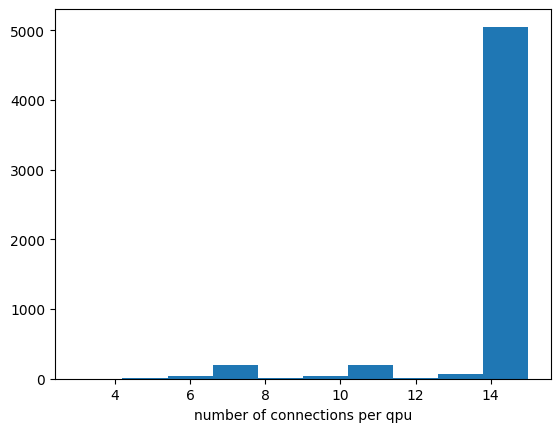

In [36]:
l = []
for node in qpu_nodes:
    l.append(len([tup for tup in qpu_edges if node in tup]))
plt.hist(l)
plt.xlabel("number of connections per qpu")
plt.show()

In [37]:
FourpGraph = dict()
FourpGraph["1"] = []
FourpGraph["2"] = []
FourpGraph["3"] = []
FourpGraph["4"] = []

FourpGraph["1"].append(qpu_nodes[0])
notIn1 = [n2 for n1,n2 in qpu_edges if FourpGraph["1"][0] == n1] + [n1 for n1,n2 in qpu_edges if FourpGraph["1"][0] == n2]


In [38]:
print(notIn1)
for node in notIn1:
    notIn2 = [n2 for n1,n2 in qpu_edges if node == n1] + [n1 for n1,n2 in qpu_edges if node == n2]
    notIn1n2 = [node2 for node2 in notIn2 if node2 in notIn1]
    print(node, notIn2, notIn1n2)

[31, 45, 2940, 2955, 2970, 2985]
31 [32, 46, 3120, 3135, 3150, 3165, 30] []
45 [46, 2940, 2955, 2970, 2985, 30] [2940, 2955, 2970, 2985]
2940 [2941, 2955, 30, 45, 180, 195] [2955, 45]
2955 [2956, 30, 45, 180, 195, 2940] [45, 2940]
2970 [2971, 2985, 30, 45, 120, 135, 150, 165, 180, 195] [2985, 45]
2985 [2986, 30, 45, 120, 135, 150, 165, 180, 195, 2970] [45, 2970]


In [39]:
[n2 for n1,n2 in qpu_edges if 45 == n1] + [n1 for n1,n2 in qpu_edges if 45 == n2]

[46, 2940, 2955, 2970, 2985, 30]

In [40]:
shft = qpu_sampler.nodelist[1]
ar = torch.zeros(np.max(qpu_sampler.nodelist)+1, np.max(qpu_sampler.nodelist)+1)
for node in qpu_sampler.nodelist:
    for adj in qpu_sampler.adjacency[node]:
        ar[node, adj] = 1
        ar[adj, node] = 1
    

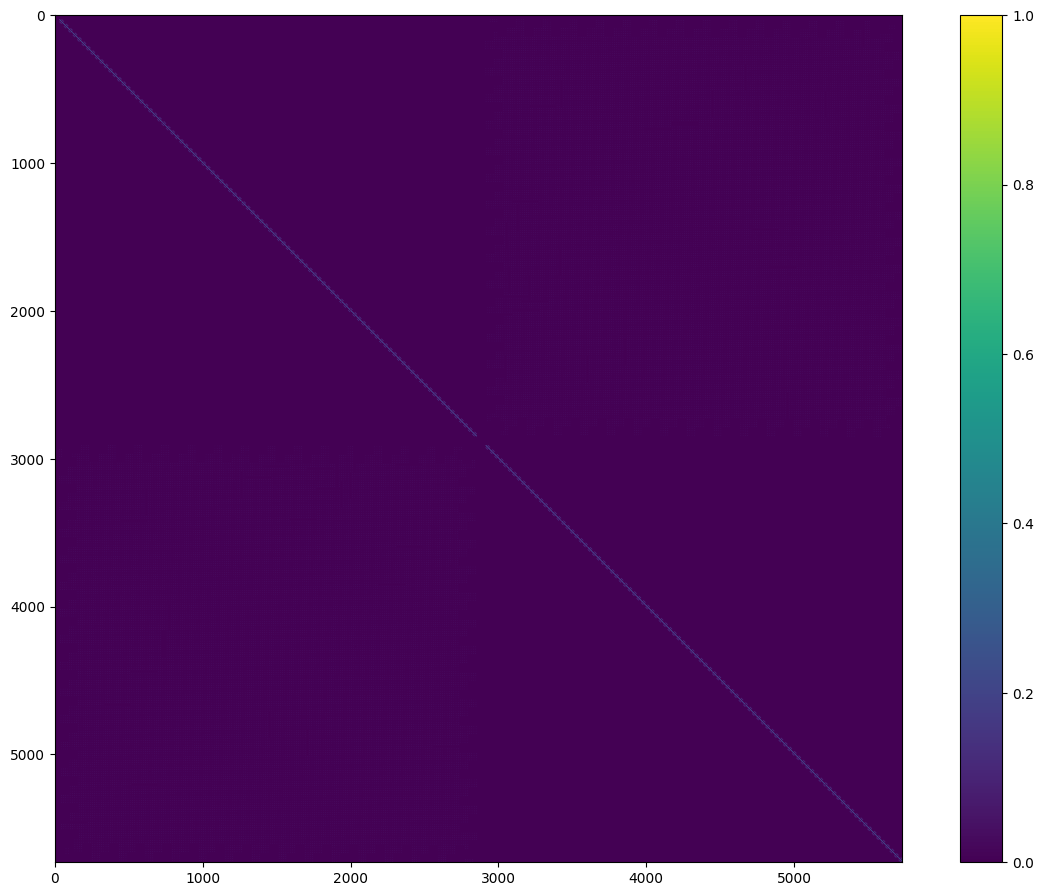

In [41]:
plt.figure(figsize=(15,11))
plt.imshow(ar.numpy())
plt.colorbar()

In [42]:
ar[1100:1110,:5410].sum(dim=1)

tensor([15., 15., 15., 15., 15., 15., 15., 15., 14.,  2.])

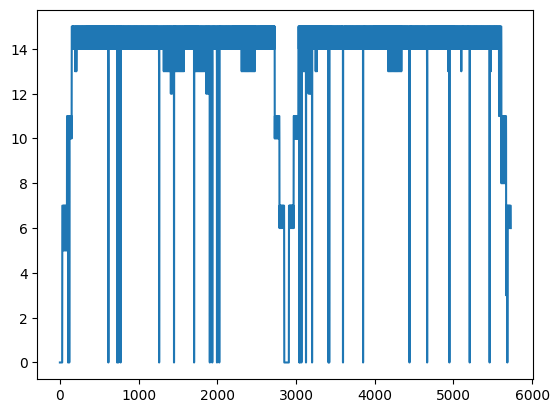

In [43]:
aa = ar.sum(dim=1).numpy()
plt.plot(aa)

In [44]:
qpu_edgelist = qpu_sampler.edgelist
qpu_nodelist = qpu_sampler.nodelist

# ar is the adj matrix
ar = torch.zeros(np.max(qpu_nodelist)+1, np.max(qpu_nodelist)+1)
# It's not clear if adjacency implies connection. Better to rely on edgelist = active couplings
# for node in qpu_sampler.nodelist:
#     for adj in qpu_sampler.adjacency[node]:
#         ar[node, adj] = 1
#         ar[adj, node] = 1

for (x,y) in qpu_edgelist:
    ar[x, y] = 1
    ar[y, x] = 1

# We select qbits with 15 connections each. ~4k
a = ar.sum(dim=1).sort()
t = a.indices[a.values >= 1]
idx = torch.randperm(t.shape[0])
arIdx15 = list(t[idx].numpy())
# arIdx15 = list(t.numpy())

In [45]:
# Abhi's idxs
arIdx15 = abhiIdxs

NameError: name 'abhiIdxs' is not defined

In [46]:
qpu_edgelist = qpu_sampler.edgelist
qpu_nodelist = qpu_sampler.nodelist

idx_dict, device = pp.gen_qubit_idx_dict()
ps = ["0","1","2","3"]
# Checks that no qbit in a given partition has connections with qbits in same partition
# If nothing gets printed => Good!
for p in ps:
    # print(p)
    for i in idx_dict[p]:
        checkTuples = [item for item in qpu_edgelist if i in item]
        for j in idx_dict[p]:
            if i != j:
                checkTuples2 = [item for item in checkTuples if j in item]
                assert checkTuples2 == []
                
                
l = []
for k,p in enumerate(ps):
    for q in ps[k+1:]:
        if p != q:
            l=[]
            # print(p,q)
            for i in idx_dict[p]:
                checkTuples = [item for item in qpu_edgelist if i in item]
                for j in idx_dict[q]:
                    if i != j:
                        l = l + [item for item in checkTuples if j in item]
            assert l != []

NameError: name 'pp' is not defined

In [47]:
RBMtoQPUIdx = dict()
for p in ps:
    tmp = dict()
    for i, qbitIdx in enumerate(FourpGraph[p]):
        tmp[qbitIdx] = i
    RBMtoQPUIdx[p] = tmp
    


NameError: name 'ps' is not defined

In [48]:
FourpGraph = dict()
FourpGraph["1"] = []
FourpGraph["2"] = []
FourpGraph["3"] = []
FourpGraph["4"] = []

gpu


p1 = 30
checkTuples = [item for item in qpu_sampler.edgelist if p1 in item]
checkTuples
p2 = 31
notInp1np2=[45,2940,2955,2970,2985]
for it in notInp1np2:
    checkTuples = [item for item in qpu_sampler.edgelist if it in item]
    print([item for item in checkTuples if p2 in item])
# checkTuples2 = [item for item in checkTuples if p2 in item]
# checkTuples2

NameError: name 'gpu' is not defined

In [ ]:
# We build RBM masking
weight_mask = dict()
weight_mask["01"] = torch.zeros(len(FourpGraph["1"]), len(FourpGraph["2"]))
weight_mask["02"] = torch.zeros(len(FourpGraph["1"]), len(FourpGraph["3"]))
weight_mask["03"] = torch.zeros(len(FourpGraph["1"]), len(FourpGraph["4"]))

weight_mask["12"] = torch.zeros(len(FourpGraph["2"]), len(FourpGraph["3"]))
weight_mask["13"] = torch.zeros(len(FourpGraph["2"]), len(FourpGraph["4"]))

weight_mask["23"] = torch.zeros(len(FourpGraph["3"]), len(FourpGraph["4"]))


c = []
for (x,y) in qpu_sampler.edgelist:
    if x in arIdx15 and y in arIdx15:
        if x in FourpGraph["1"]:
            n = 0
            pIdx = "1"
        elif x in FourpGraph["2"]:
            n = 1
            pIdx = "2"
        elif x in FourpGraph["3"]:
            n = 2
            pIdx = "3"
        elif x in FourpGraph["4"]:
            n = 3
            pIdx = "4"
        else:
            c.append(x)
            n = -1
            pIdx = "0"

        if y in FourpGraph["1"]:
            m = 0
            qIdx = "1"
        elif y in FourpGraph["2"]:
            m = 1
            qIdx = "2"
        elif y in FourpGraph["3"]:
            m = 2
            qIdx = "3"
        elif y in FourpGraph["4"]:
            m = 3
            qIdx = "4"
        else:
            c.append(y)
            m = -1
            qIdx = "0"

        if n != -1 and m != -1 and m != n and qIdx != "0" and pIdx != "0":
            key = str(min(n,m)) + str(max(n,m))
            if int(pIdx) < int(qIdx):
                weight_mask[key][RBMtoQPUIdx[pIdx][x], RBMtoQPUIdx[qIdx][y]] = 1
            else:
                weight_mask[key][RBMtoQPUIdx[qIdx][y], RBMtoQPUIdx[pIdx][x]] = 1

c = list(np.unique(c))
assert remainder0 == c

In [ ]:
plt.hist(weight_mask['01'].sum(dim=1).numpy(), alpha = 0.5)
# plt.hist(weight_mask['02'].sum(dim=1).numpy(), alpha = 0.5)
# plt.hist(weight_mask['03'].sum(dim=1).numpy(), alpha = 0.5)
# plt.hist(weight_mask['12'].sum(dim=1).numpy(), alpha = 0.5)
# plt.hist(weight_mask['13'].sum(dim=1).numpy(), alpha = 0.5)
# plt.hist(weight_mask['23'].sum(dim=1).numpy(), alpha = 0.5)
plt.show()

In [ ]:
weight_mask['01'].shape

In [ ]:
plt.imshow(engine.model.prior.weights_mask.abs().sign().detach().cpu().numpy()[:200,:200])
plt.colorbar()

In [ ]:
plt.hist(engine.model.prior.weights_mask.abs().sign().sum(dim=1).detach().cpu().numpy())
plt.hist(engine.model.prior.weights_mask.sum(dim=1).detach().cpu().numpy())

In [49]:
from models.rbm.pegasusRBM import PegasusRBM

In [115]:
pp = PegasusRBM(512)

2024-05-31 13:21:44,267 dwave.cloud.client.base INFO  MainThread Fetching available regions from the Metadata API at 'https://cloud.dwavesys.com/metadata/v1/'
[13:21:44.267] INFO   dwave.cloud.client.base                           Fetching available regions from the Metadata API at 'https://cloud.dwavesys.com/metadata/v1/'
2024-05-31 13:21:45,605 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[13:21:45.605] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2024-05-31 13:21:46,438 dwave.cloud.client.base INFO  MainThread Fet

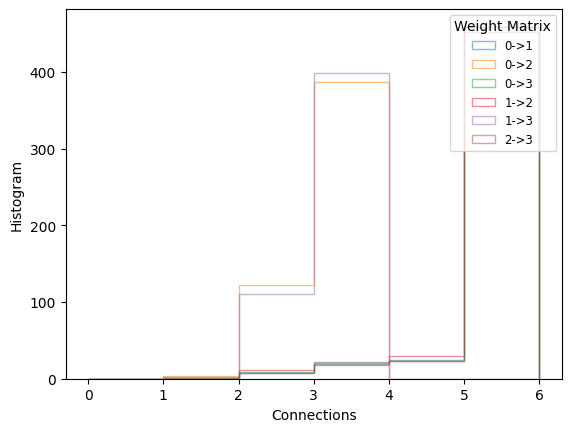

In [116]:

plt.hist(pp._weight_mask_dict['01'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.hist(pp._weight_mask_dict['02'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.hist(pp._weight_mask_dict['03'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.hist(pp._weight_mask_dict['12'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.hist(pp._weight_mask_dict['13'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.hist(pp._weight_mask_dict['23'].sum(dim=1).numpy(), bins=np.arange(0, 6 + 1,1), alpha = 0.5,  histtype='step')
plt.legend(["0->1","0->2","0->3","1->2","1->3","2->3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
plt.xlabel("Connections")
plt.ylabel("Histogram")
plt.show()

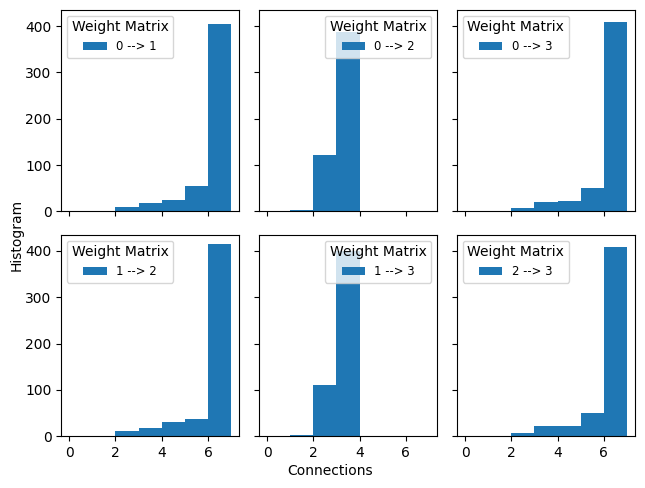

In [117]:
n_bins =  bins=np.arange(0, 8,1)
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, 0.0, 'Connections', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# We can set the number of bins with the *bins* keyword argument.
axs[0,0].hist(pp._weight_mask_dict['01'].sum(dim=1).numpy(), bins=n_bins)
axs[0,0].legend(["0 --> 1"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
axs[0,1].hist(pp._weight_mask_dict['02'].sum(dim=1).numpy(), bins=n_bins)
axs[0,1].legend(["0 --> 2","0->3","1->2","1->3","2->3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
axs[0,2].hist(pp._weight_mask_dict['03'].sum(dim=1).numpy(), bins=n_bins)
axs[0,2].legend(["0 --> 3","1->2","1->3","2->3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
axs[1,0].hist(pp._weight_mask_dict['12'].sum(dim=1).numpy(), bins=n_bins)
axs[1,0].legend(["1 --> 2","1->3","2->3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
axs[1,1].hist(pp._weight_mask_dict['13'].sum(dim=1).numpy(), bins=n_bins)
axs[1,1].legend(["1 --> 3","2->3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
axs[1,2].hist(pp._weight_mask_dict['23'].sum(dim=1).numpy(), bins=n_bins)
axs[1,2].legend(["2 --> 3"], title="Weight Matrix",
                   fontsize='small', fancybox=True)
# plt.xlabel("Connections", fontsize='medium')
# plt.ylabel("Histogram")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/Pegasus_weight_matrices.png', dpi=300)
plt.show()

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape:  (512, 512)
(array([  0,   0,   9,  19,  25,  54, 405]), array([0, 1, 2, 3, 4, 5, 6, 7]))
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 

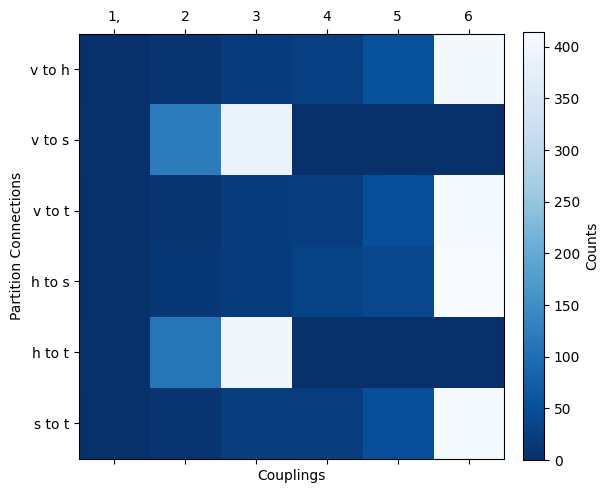

In [132]:
import numpy as np
dependencies = ["v to h", "v to s", "v to t", "h to s", "h to t", "s to t"]
couplings = ['1,', '2', '3', '4', '5', '6']

counts = np.zeros([6,6])
print(counts)
print("shape: ", pp._weight_mask_dict['01'].numpy().shape)
print((np.histogram(pp._weight_mask_dict['01'].sum(dim=1).numpy(), bins=n_bins)))
counts[0,:] = (((np.histogram(pp._weight_mask_dict['01'].sum(dim=1).numpy(), bins=n_bins))[0])[1:7])
counts[1,:] = (((np.histogram(pp._weight_mask_dict['02'].sum(dim=1).numpy(), bins=n_bins))[0])[1:7])
counts[2,:] = (((np.histogram(pp._weight_mask_dict['03'].sum(dim=1).numpy(), bins=n_bins))[0])[1:7])
counts[3,:] = (((np.histogram(pp._weight_mask_dict['12'].sum(dim=1).numpy(), bins=n_bins))[0])[1:7])
counts[4,:] = (((np.histogram(pp._weight_mask_dict['13'].sum(dim=1).numpy(), bins=n_bins))[0])[1:7])
counts[5,:] = (((np.histogram(pp._weight_mask_dict['23'].sum(dim=1).numpy(), bins=n_bins))[0])[1:7])

print(pp._weight_mask_dict['02'].sum(dim=0).numpy())
print(counts)
print(counts[1,:])

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(counts, interpolation='nearest', cmap='Blues_r')

# Set axis ticks and labels
ax.set_aspect('equal')
ax.set_yticks(range(len(dependencies)))
ax.set_yticklabels(dependencies)
ax.set_ylabel("Partition Connections")

ax.set_xticks(range(len(couplings)))
ax.set_xticklabels(couplings)
ax.set_xlabel("Couplings")

# Add colorbar with the same height as the graph
cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Counts')

plt.show()



In [ ]:
idx_dict, device = pp.gen_qubit_idx_dict()

In [ ]:
idx_dict.keys()

In [ ]:
abhiIdxs = torch.cat([torch.tensor(idx_dict[key]) for key in idx_dict.keys()]) #.sort().values
abhiIdxs = list(abhiIdxs.numpy())

In [ ]:
from models.rbm.chimerav2 import QimeraRBM

In [ ]:
pp = QimeraRBM(500, 500)

In [ ]:
pp.check_partition()

In [ ]:
pp._weight_mask_dict['01'].shape
pp._weights_mask.shape

In [ ]:
# len(pp._visible_qubit_idxs)
plt.hist(pp._weights_mask.sum(dim=1).numpy(), alpha = 0.5)

In [ ]:
import dwave_networkx as dnx
_QPU_PSIZE = 16
coords = dnx.pegasus_coordinates(_QPU_PSIZE)

In [ ]:
coords

In [ ]:
# from models.rbm.pegasusRBM import PegasusRBM

In [ ]:
idx_dict, device = pp.gen_qubit_idx_dict()

In [ ]:
len(idx_dict['0'])

In [ ]:
# pp._pruned_edge_list

In [ ]:
from models.rbm.pegasusRBM import PegasusRBM
pp = PegasusRBM(1024, 1024)

In [ ]:
plt.hist(pp._weight_mask_dict['03'].sum(dim=1).detach().numpy(), alpha = 0.5)

In [ ]:
idx_dict, device = pp.gen_qubit_idx_dict()

In [ ]:
pp._weight_dict['01']

In [ ]:
pp.pruned_edge_list[1]

In [ ]:
pp._bias_dict.keys()

In [ ]:
pp._weight_dict['01']

In [ ]:
# pp.

In [ ]:
# int('0')
a = torch.rand(10)

In [ ]:
torch.zeros(a.size(), device=a.device)

In [ ]:
a.device

In [ ]:
import numpy as np

In [ ]:
str(np.min([1,2])) + str(np.max([1,2]))

In [ ]:
torch.cat([torch.rand(10), torch.zeros(10)])

In [ ]:
torch.cat([a for i in range(2)])

In [ ]:
# pp.gen_qubit_idx_dict()
pp._qpu_sampler.properties["chip_id"]